# DGE with limma-voom
Notebook based on the following article:

Law CW, Alhamdoosh M, Su S et al. **RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR.** _F1000Research_ 2018, 5:1408 (https://doi.org/10.12688/f1000research.9005.3)

In [1]:
library(edgeR)
library(Glimma)

Loading required package: limma


## Import metadata and gene info

In [2]:
#get the metadata
metadata <- read.table(file.path('data','SraRunTable.txt'), sep='\t', header=TRUE, comment.char = '', stringsAsFactors= FALSE)
rownames(metadata) <- metadata$Run
head(metadata, n = 5)

,BioSample,Experiment,MBases,MBytes,Run,SRA_Sample,Sample_Name,individual,treatment,Assay_Type,⋯,LibraryLayout,LibrarySelection,LibrarySource,LoadDate,Organism,Platform,ReleaseDate,SRA_Study,cell_type,source_name
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SRR8914928,SAMN11439856,SRX5696382,4330,1693,SRR8914928,SRS4635590,GSM3724893,Healthy volunteer #32,Unstimulated,RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914929,SAMN11439855,SRX5696383,3898,1516,SRR8914929,SRS4635592,GSM3724894,Healthy volunteer #42,Unstimulated,RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914930,SAMN11439854,SRX5696384,3745,1462,SRR8914930,SRS4635591,GSM3724895,Healthy volunteer #43,Unstimulated,RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914931,SAMN11439853,SRX5696385,3437,1344,SRR8914931,SRS4635594,GSM3724896,Healthy volunteer #32,T(anti-CD3/CD28 beads only),RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC
SRR8914932,SAMN11439852,SRX5696386,3358,1311,SRR8914932,SRS4635593,GSM3724897,Healthy volunteer #42,T(anti-CD3/CD28 beads only),RNA-Seq,⋯,PAIRED,cDNA,TRANSCRIPTOMIC,2019-04-16,Homo sapiens,ILLUMINA,2019-04-18,SRP192764,Live CD3+CD8+TCR-Valpha7.2,PBMC


In [3]:
#get gene info
genes <- read.table(file.path('data','gene_info.csv'), sep=',', header=TRUE, row.names = 1, , stringsAsFactors= FALSE)
head(genes)

,Gene.symbol
,<chr>
ENSG00000000003.14,TSPAN6
ENSG00000000005.5,TNMD
ENSG00000000419.12,DPM1
ENSG00000000457.13,SCYL3
ENSG00000000460.16,C1orf112
ENSG00000000938.12,FGR


## Import counts generated by [tximport](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html)

Because limma-voom does not use the offset matrix stored in  y$offset, we recommend using the scaled counts generated from abundances, either "scaledTPM" or "lengthScaledTPM":

In [4]:
cts <- read.table(file.path('quant','txi_scaledTPM_counts.csv'), sep=',', header=TRUE, row.names = 1)
head(cts)

,SRR8914928,SRR8914929,SRR8914930,SRR8914931,SRR8914932,SRR8914933,SRR8914934,SRR8914935,SRR8914936,SRR8914937,SRR8914938,SRR8914939
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,34.53786,35.27796,41.90729,32.44777,56.29125,33.23137,16.87271,9.968845,25.74415,11.80625,12.746009,22.15390
ENSG00000000005.5,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000
ENSG00000000419.12,842.33432,1049.44763,1048.51865,1135.74833,1127.10242,1062.90160,1440.40560,1701.277657,2361.89283,1866.85980,1743.868864,2096.50197
ENSG00000000457.13,307.18077,382.56574,281.99467,300.65064,302.67007,315.80471,275.09613,336.414431,282.14784,304.68052,226.927385,262.76941
ENSG00000000460.16,77.67088,61.81353,58.98115,49.12788,62.08434,44.79703,46.31236,25.333856,50.12617,52.40767,37.204478,52.72636
ENSG00000000938.12,23.08708,19.11158,36.58036,22.52345,30.56891,19.18923,38.71051,15.361539,17.65741,17.22260,2.790241,15.55256


In [5]:
?DGEList

DGEList {edgeR},R Documentation
counts,numeric matrix of read counts.
lib.size,numeric vector giving the total count (sequence depth) for each library.
norm.factors,numeric vector of normalization factors that modify the library sizes.
samples,data frame containing information for each sample.
group,vector or factor giving the experimental group/condition for each sample/library.
genes,data frame containing annotation information for each gene.
remove.zeros,"logical, whether to remove rows that have 0 total count."


In [6]:
y <- DGEList(cts, group= metadata$treatment, genes= genes)
y$samples$individual <- metadata$individual
# filtering
keep <- filterByExpr(y, group= metadata$treatment)
y <- y[keep, ]
#check the number of genes that passed filtering
nrow(y$genes)

[1] 15973

## Normalising gene expression distributions
During the sample preparation or sequencing process, external factors that are not of biological interest can affect the expression of individual samples. For example, samples processed in the 1st batch of an experiment can have higher expression overall when compared to samples processed in a second batch. It is assumed that all samples should have a similar range and distribution of expression values. Normalisation is required to ensure that the expression distributions of each sample are similar across the entire experiment.
Any plot showing the per sample expression distributions, such as a density or boxplot, is useful in determining whether any samples are dissimilar to others. 
Normalisation by the method of trimmed mean of M-values (TMM) is performed using the calcNormFactors function in edgeR. The normalisation factors calculated here are used as a scaling factor for the library sizes. When working with DGEList-objects, these normalisation factors are automatically stored in x\$samples$norm.factors. For this dataset the effect of TMM-normalisation is mild, as evident in the magnitude of the scaling factors, which are all relatively close to 1.

In [7]:
#normalise with edgeR
y <- calcNormFactors(y)
y$samples

,group,lib.size,norm.factors,individual
,<fct>,<dbl>,<dbl>,<chr>
SRR8914928,Unstimulated,25188860,1.0443978,Healthy volunteer #32
SRR8914929,Unstimulated,22582461,1.3002725,Healthy volunteer #42
SRR8914930,Unstimulated,20958622,1.3127456,Healthy volunteer #43
SRR8914931,T(anti-CD3/CD28 beads only),21019073,1.0435082,Healthy volunteer #32
SRR8914932,T(anti-CD3/CD28 beads only),20115482,1.1709068,Healthy volunteer #42
SRR8914933,T(anti-CD3/CD28 beads only),25664622,0.8848662,Healthy volunteer #43
SRR8914934,"C(cytokines, IL-12/-15/-18/TL1A)",24379813,0.9107321,Healthy volunteer #32
SRR8914935,"C(cytokines, IL-12/-15/-18/TL1A)",25166224,0.8835770,Healthy volunteer #42
SRR8914936,"C(cytokines, IL-12/-15/-18/TL1A)",28684227,0.7930361,Healthy volunteer #43


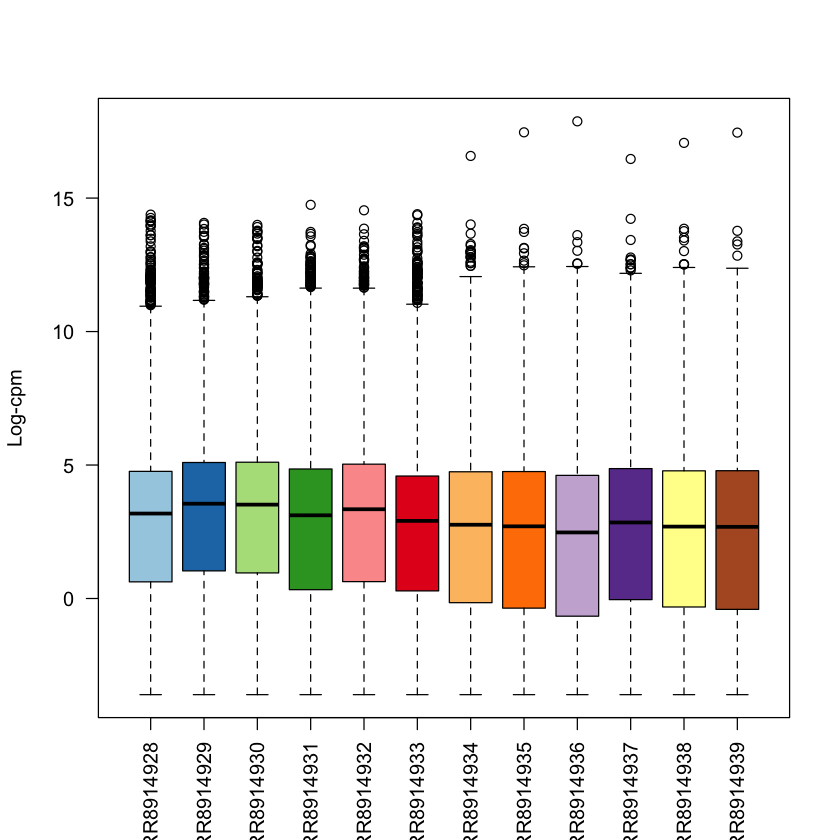

In [8]:
library(RColorBrewer)
nsamples <- ncol(cts)
col <- brewer.pal(nsamples, "Paired")
boxplot(cpm(y$counts, log=TRUE),las=2, col=col)
title(ylab="Log-cpm")

## Unsupervised clustering

In [9]:
lcpm <- cpm(y$counts, log= TRUE)
glMDSPlot(lcpm, labels= rownames(y$samples), groups= y$samples[,c('group','individual')], launch=TRUE)

## DGE

### Creating a design matrix and contrasts

In this study, it is of interest to see which genes are expressed at different levels between the 2 groups. In our analysis, linear models are  fitted to the data with the assumption that the underlying data is normally distributed. To get started, a design matrix is set up with treatment information.

In [10]:
design <- model.matrix(~0 + treatment + individual, data = metadata)
colnames(design) = c('Cytokines','TCR','TCR_Cytokines','Unstim', 'individual_42', 'individual_43')
#check that samples are assigned to the correct groups
design

,Cytokines,TCR,TCR_Cytokines,Unstim,individual_42,individual_43
SRR8914928,0,0,0,1,0,0
SRR8914929,0,0,0,1,1,0
SRR8914930,0,0,0,1,0,1
SRR8914931,0,1,0,0,0,0
SRR8914932,0,1,0,0,1,0
SRR8914933,0,1,0,0,0,1
SRR8914934,1,0,0,0,0,0
SRR8914935,1,0,0,0,1,0
SRR8914936,1,0,0,0,0,1
SRR8914937,0,0,1,0,0,0


For a given experiment, there are usually several equivalent ways to set up an appropriate design matrix. For example, ~0+group removes the intercept from the 1st factor, group. Alternatively, ~group could be used to keep the intercepts in group. Understanding how to interpret the coefficients estimated in a given model is key here. We choose the 1st model for our analysis, as setting up model contrasts is more straight forward in the absence of an intercept for group. Contrasts for pairwise comparisons between cell populations are set up in limma using the makeContrasts function.

A key strength of limma’s linear modelling approach is the ability accommodate arbitrary experimental complexity. Simple designs, such as the one in this workflow, through to more complicated factorial designs and models with interaction terms can be handled relatively easily. Where experimental or technical effects can be modelled using a random effect, another possibility in limma is to estimate correlations using duplicateCorrelation by specifying a block argument for both this function and in the lmFit linear modelling step.

In [11]:
contr.matrix <- makeContrasts(TC_vs_Unstim = TCR_Cytokines - Unstim,
                              T_vs_Unstim = TCR - Unstim,
                              C_vs_Unstim = Cytokines - Unstim,
                              levels = colnames(design))
contr.matrix

,TC_vs_Unstim,T_vs_Unstim,C_vs_Unstim
Cytokines,0,0,1
TCR,0,1,0
TCR_Cytokines,1,0,0
Unstim,-1,-1,-1
individual_42,0,0,0
individual_43,0,0,0


### Removing heteroscedascity from count data

It has been shown that for RNA-seq count data, the variance is not independent of the mean – this is true of raw counts or when transformed to log-CPM values. Methods that model counts using a Negative Binomial distribution assume a quadratic mean-variance relationship. In limma, linear modelling is carried out on the log-CPM values which are assumed to be normally distributed and the mean-variance relationship is accommodated using precision weights calculated by the voom function.
When operating on a DGEList-object, voom converts raw counts to log-CPM values by automatically extracting library sizes and normalisation factors from x itself. Additional normalisation to log-CPM values can be specified within voom using the normalize.method argument.

The mean-variance relationship of log-CPM values for this dataset is shown in Figure 4A. Typically, the “voom-plot” shows a decreasing trend between the means and variances resulting from a combination of technical variation in the sequencing experiment and biological variation amongst the replicate samples from different cell populations. Experiments with high biological variation usually result in  atter trends, where variance values plateau at high expression values. Experiments with low biological variation tend to result in sharp decreasing trends.

Moreover, the voom-plot provides a visual check on the level of filtering performed upstream. If filtering of lowly-expressed genes is insufficient, a drop in variance levels can be observed at the low end of the expression scale due to very small counts. If this is observed, one should return to the earlier filtering step and increase the expression threshold applied to the dataset.

Where sample-level variation is evident from earlier inspections of the MDS plot, the voomWithQualityWeights function can be used to simultaneously incorporate sample-level weights together with the abundance dependent weights estimated by voom. For an example of this approach, see Liu et al. (2016).

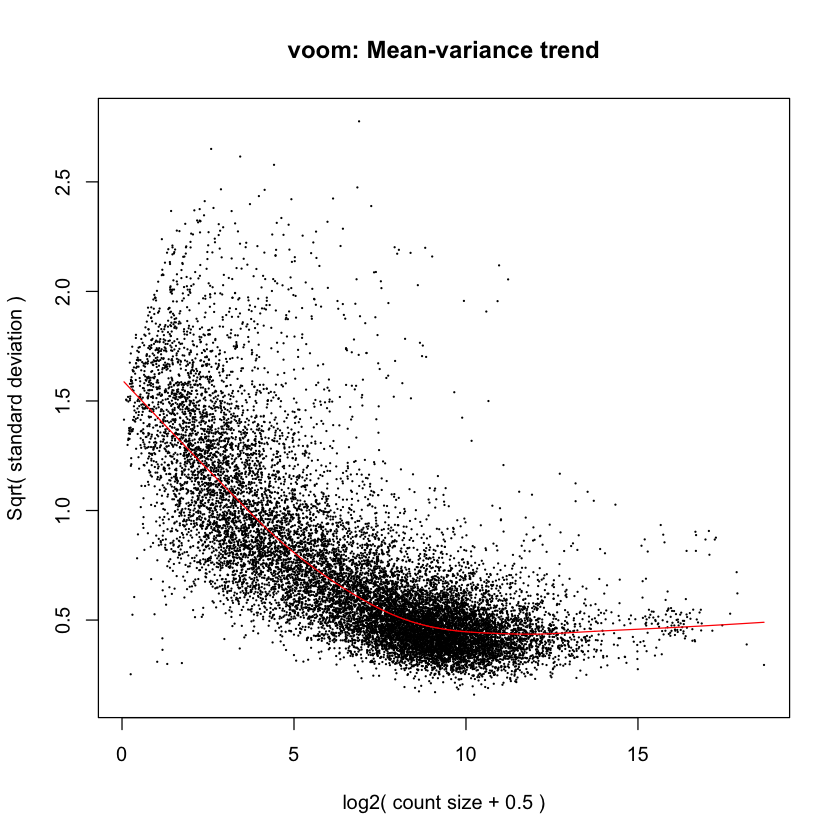

In [12]:
v <- voom(y, design, plot=TRUE)

v is now ready for lmFit() see limma [User's Guide](https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf)

### Fitting linear models for comparisons of interest

Linear modelling in limma is carried out using the lmFit and contrasts.fit functions originally written for application to microarrays. The functions can be used for both microarray and RNA-seq data and  t a separate model to the expression values for each gene. Next, empirical Bayes moderation is carried out by borrowing information across all genes to obtain more precise estimates of gene-wise variability. The model’s residual variances are plotted against average expression values in the figure below. It can be seen from this plot that the variance is no longer dependent on the mean expression level.

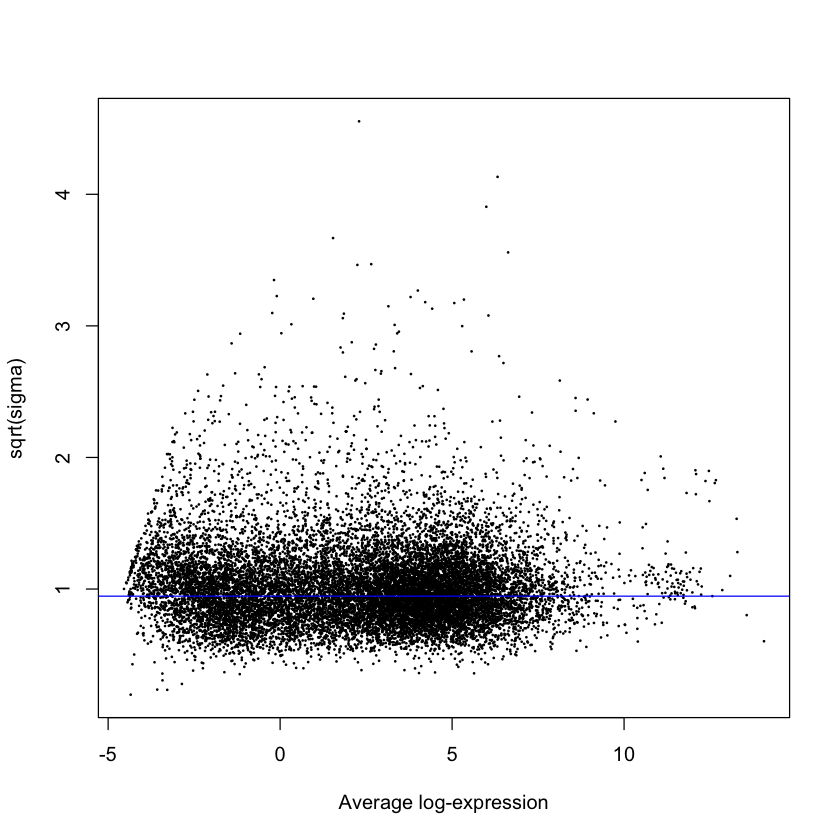

In [13]:
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=contr.matrix)
efit <- eBayes(vfit)
plotSA(efit)

### Examining the number of DE genes

For a quick look at differential expression levels, the number of significantly up- and down-regulated genes can be summarised in a table. Significance is defined using an adjusted p-value cutoff that is set at 5% by default.

In [14]:
summary(decideTests(efit))

       TC_vs_Unstim T_vs_Unstim C_vs_Unstim
Down           4662         667        4272
NotSig         6909       14038        7470
Up             4402        1268        4231

Some studies require more than an adjusted p-value cutoff. For a stricter definition on significance, one may require log-fold-changes (log-FCs) to be above a minimum value. The treat method can be used to calculate p-values from empirical Bayes moderated t-statistics with a minimum log-FC requirement. The number of differentially expressed genes are reduced when testing requires genes to have a log-FC that is significantly greater than 1 (equivalent to a 2-fold difference between cell types on the original scale).

In [15]:
tfit <- treat(vfit, lfc=1)
dt <- decideTests(tfit)
summary(dt)

       TC_vs_Unstim T_vs_Unstim C_vs_Unstim
Down           1370           9        1044
NotSig        13238       15931       13791
Up             1365          33        1138

### Examining individual DE genes from top to bottom

The top DE genes can be listed using topTreat for results using treat (or topTable for results using eBayes). By default topTreat arranges genes from smallest to largest adjusted p-value with associated gene information, log-FC, average log-CPM, moderated t-statistic, raw and adjusted p-value for each gene. The number of top genes displayed can be speci ed, where n=Inf includes all genes. Genes Cldn7 and Rasef are amongst the top DE genes for both basal versus LP and basal versus ML.

In [20]:
dge <- topTreat(tfit, coef=1, n=Inf)
#export DGE results (those are the results for the 1st column in tfit i.e. TC vs Unstim)
write.csv(as.data.frame(dge),file= file.path('data','DGE_limma-voom.csv'))
head(dge)

,Gene.symbol,logFC,AveExpr,t,P.Value,adj.P.Val
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000226979.8,LTA,6.824180,7.936664,34.66689,2.012180e-11,3.214055e-07
ENSG00000135069.13,PSAT1,6.661267,6.247141,25.45467,3.445709e-10,2.210408e-06
ENSG00000136810.12,TXN,4.139862,7.634541,24.80913,4.151521e-10,2.210408e-06
ENSG00000111536.4,IL26,6.805388,5.057748,22.12188,1.250895e-09,3.926510e-06
ENSG00000081059.19,TCF7,-5.939592,5.493597,-21.83371,1.381054e-09,3.926510e-06
ENSG00000100453.12,GZMB,8.075604,9.279798,21.80555,1.474930e-09,3.926510e-06


* Useful graphical representations of differential expression results

To summarise results for all genes visually, mean-difference plots, which display log-FCs from the linear model  t against the average log-CPM values can be generated using the plotMD function, with the differentially expressed genes highlighted.

Glimma extends this functionality by providing an interactive mean-difference plot via the glMDPlot function. The output of this function is an html page, with summarised results in the left panel (similar to what is output by plotMD), and the log-CPM values from individual samples for a selected gene in the right panel, with a table of results below the plots. This interactive display allows the user to search for particular genes based on the annotation provided (e.g. Gene symbol identifier), which is not possible in a static R plot.

In [18]:
x <- 1:length(colnames(tfit))
for (i in x)
{
    glMDPlot(tfit[,i], coef=1, status=dt[,i], main=colnames(tfit)[i], side.main="Gene.symbol", counts=y$counts, groups=y$samples$group, launch=TRUE)
}

Heatmaps allow users to look at the expression of a subset of genes. This can give useful insight into the expression of individual groups and samples without losing perspective of the overall study when focusing on individual genes, or losing resolution when examining patterns averaged over thousands of genes at the same time.


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



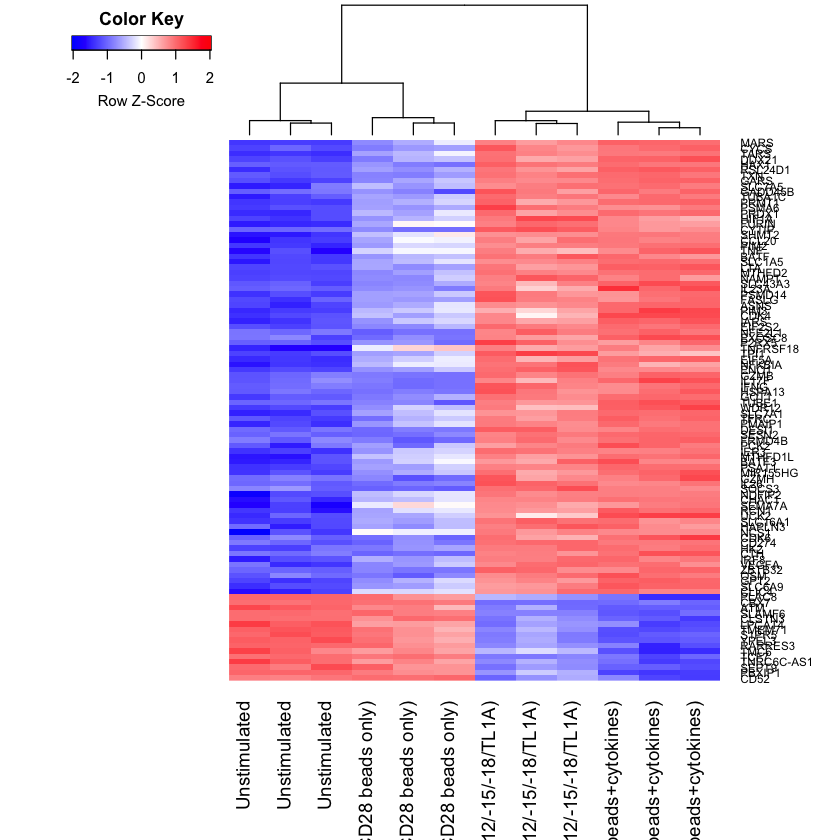

In [19]:
library(gplots)
# select the top 100 dge (sorted by p-val)
dge_topgenes <- dge$Gene.symbol[1:100]
i <- which(v$genes$Gene.symbol %in% dge_topgenes)
mycol <- colorpanel(1000,"blue","white","red")
heatmap.2(v$E[i,], scale="row",labRow=v$genes$Gene.symbol[i], labCol= metadata$treatment, col=mycol, trace="none", density.info="none", margin=c(8,6), lhei=c(2,10), dendrogram="column")
